## Name: 
藍筱雁


## Student ID: 
107062502




# Change JSON into CSV

In [15]:
import json
import pandas as pd
import csv
import nltk

Handle tweets_DM.json into all.csv

In [454]:
file = open("all.csv", "w")
f = csv.writer(file)
f.writerow(['tweet_id','text','hashtags']) # which features I want

with open('tweets_DM.json','r') as inputfile:
    for line in inputfile:
        raw = json.loads(line)
        tweet = raw['_source']['tweet']
        tweet_id = tweet['tweet_id']
        f.writerow([tweet_id,tweet['text'],tweet['hashtags']])
file.close()

To split data into train_df and test_df.

In [455]:
identify = pd.read_csv('data_identification.csv')
emotion_label = pd.read_csv('emotion.csv')
raw = pd.read_csv('all.csv')
temp_df = pd.merge(raw,identify,on='tweet_id')
test_df = temp_df[temp_df['identification'] == 'test']
train_df = temp_df[temp_df['identification'] == 'train']

drop the column that I don't need.

In [456]:
train_df = pd.merge(train_df,emotion_label,on='tweet_id') 
train_df = train_df.drop('identification',axis = 1)
test_df = test_df.drop('identification',axis = 1)


---------

# Preprocessing

- Text processing
- Feature Engineering

------

## Text processing

Firstly, I lower the sentences, remove '< LH >'and replace some words.

In [457]:
train_df['text'] = train_df['text'].apply(lambda x: x.lower())
test_df['text'] = test_df['text'].apply(lambda x: x.lower())

In [458]:
replace_list = [('<LH>',''),('\n',' '),('\r',' '),('\t',' '),("n't",' not'),("it's",'it is'),("'m",' am'),
               ("'re",' are'),("é",'e'),("it’s",'it is'),("'ve",' have'),('T.T','😭'),(':)','😄'),("that's",'that is')
               ,("'ll",' will'),("That’s",'that is'),('☺','😄'),('-_-','😓')]

In [459]:
for older,newer in replace_list:
    train_df['text'] = train_df['text'].apply(lambda x: x.replace(older,newer))
    test_df['text'] = test_df['text'].apply(lambda x: x.replace(older,newer))


In [460]:
# from nltk.stem.snowball import SnowballStemmer
pattern = r"[a-zA-Z-_]+|[@\#]?\w+(?:[-']\w+)*|[\u263a-\U0001ffff]|/d+[.'/]/d+"

In [465]:
def myTokenizer(text):
    words = []
    emoji = []
    for word in nltk.regexp_tokenize(text, pattern):
        word = word.replace(' ','')
        if(word == 'lh' or len(word) == 0 or word == '🇸'):
            continue
        if(word == '🇺'): #because US is separated, I use this condition to add US instead.
            words.append('US')
            continue
        if(re.match(r"[\u263a-\U0001ffff]",word)): # emoji
            emoji.append(word)
            continue
        if(re.match(r'[a-zA-Z]+',word) == None): #not a word
            words.append(word)
            continue
        words.append(word)
    return words, emoji

Secondly, I use a tool called <b>SnowballStemmer</b> which is one of a stemmer in nltk. And stem each of words in all sentences. Afetr stemming each word, I join these processed words into a sentence. 

In [467]:
a,b = train_df['text'].apply(lambda sentence: myTokenizer(sentence))


ValueError: too many values to unpack (expected 2)

In [ ]:
test_df['text'],test_df['emoji'] = test_df['text'].apply(lambda sentence: myTokenizer(sentence))


In [408]:
train_df['emoji']

Index(['tweet_id', 'text', 'hashtags', 'emotion'], dtype='object')

In [409]:
train_df = train_df.drop('hashtags',axis = 1)
train_df = train_df.drop('tweet_id',axis = 1)

In [410]:
test_df = test_df.drop('hashtags',axis = 1)

to save the preprocessing reult.

In [411]:
train_df.to_csv('train_myTokenizer.csv',index=False)
test_df.to_csv('test_myTokenizer.csv',index=False)

## Feature Engineering

I will try BOW and TF-IDF and use confusion matrix to consider which I will use.

In [412]:
train_df = pd.read_csv('train_myTokenizer.csv')
test_df = pd.read_csv('test_myTokenizer.csv')



In [394]:
import ast

def my_string_Tokenizer(text):
    return ast.literal_eval(text)

In [150]:
import matplotlib.pyplot as plt
import numpy as np 
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Use LogisticRegression to check that which of BOW and TF-IDF is better.

In [151]:

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(C=2, solver='lbfgs',n_jobs=-1)
class_names = train_df['emotion'].unique()


In [157]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['text'],train_df['emotion'],test_size = 10000)

### BOW removing stop word

To build a BOW vector and try to use the parameter we learned from the lab class.

In [158]:
from sklearn.feature_extraction.text import CountVectorizer
BOW_vectorizer = CountVectorizer(max_features=65000,stop_words='english',ngram_range=(1,3),
                                tokenizer=Tokenizer,max_df=0.6,lowercase=False) 
BOW_vectorizer.fit(train_df['text'])

train_data_BOW_features = BOW_vectorizer.transform(X_train)

In [159]:
from sklearn.metrics import confusion_matrix
X_test_BOW = BOW_vectorizer.transform(X_test)
y_pred = classifier.fit(train_data_BOW_features, y_train).predict(X_test_BOW)

Confusion matrix, without normalization


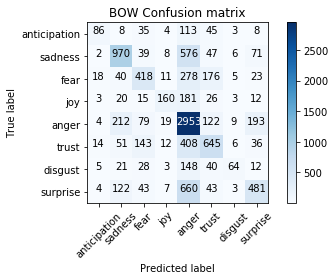

In [160]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='BOW Confusion matrix')

### BOW having stop word

In [163]:
BOW_vectorizer = CountVectorizer(max_features=65000,ngram_range=(1,3),
                                tokenizer=Tokenizer,max_df=0.6,lowercase=False) 
BOW_vectorizer.fit(train_df['text'])

train_data_BOW_features = BOW_vectorizer.transform(X_train)

In [164]:
X_test_BOW = BOW_vectorizer.transform(X_test)
y_pred = classifier.fit(train_data_BOW_features, y_train).predict(X_test_BOW)

Confusion matrix, without normalization


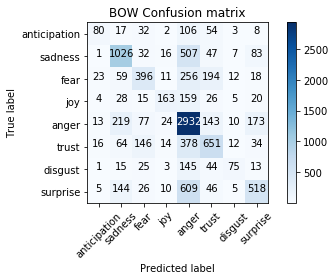

In [165]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='BOW Confusion matrix')

---------

### TF-IDF removing stop word

In [161]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=65000,stop_words='english',ngram_range=(1,3),
                                tokenizer=Tokenizer,max_df=0.6,lowercase=False)

tfidf_vectorizer.fit(train_df['text'])
X_train_tfidf = tfidf_vectorizer.transform(X_train)

In [162]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = classifier.fit(X_train_tfidf, y_train).predict(X_test_tfidf)

Confusion matrix, without normalization


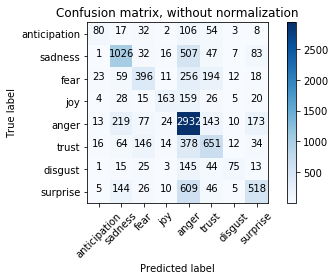

In [166]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

### TF-IDF having stop word

In [389]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=65000,ngram_range=(1,3),
                                tokenizer=my_string_Tokenizer,max_df=0.6,lowercase=False)

tfidf_vectorizer.fit(train_df['text'])
X_train_tfidf = tfidf_vectorizer.transform(X_train)

['people', 'who', 'post', 'add', 'me', 'on', '#snapchat', 'must', 'be', 'dehydrated', 'cuz', 'man', 'that', 'is']
['@brianklaas', 'as', 'we', 'see', 'trump', 'is', 'dangerous', 'to', '#freepress', 'around', 'the', 'world', 'what', 'a', '#trumplegacy', '#cnn']
['now', 'issa', 'is', 'stalking', 'tasha', '😂', '😂', '😂']
['@riskshow', '@thekevinallison', 'thx', 'for', 'the', 'best', 'time', 'tonight', 'what', 'stories', 'heartbreakingly', '#authentic', '#laughoutloud', 'good']
['still', 'waiting', 'on', 'those', 'supplies', 'liscus']
['love', 'knows', 'no', 'gender', '😢', '😭']
['@dstvngcare', '@dstvng', 'more', 'highlights', 'are', 'being', 'shown', 'than', 'actual', 'sports', 'who', 'watches', 'triathlon', 'highlights', 'anyway', '#leaguecup']
['the', '#ssm', 'debate', 'a', 'manufactured', 'fantasy', 'used', 'to', 'distract', 'the', 'ignorant', 'masses', 'from', 'their', 'mundane', 'lives', 'v', '#gender', '#diversity', 'a', 'm']
['i', 'love', 'suffering', '🙃', '🙃', 'i', 'love', 'when', 'v

['@atharluvsrk', 'looking', 'always']
['who', 'else', 'credit', 'diply', '#life']
['how', 'can', 'we', 'save', 'the', '@carmichaelshow', '@nbc', 'is', 'to', 'let', 'this', 'show', 'go', '@iknoro', 'there', 'gotta', 'be', 'something', 'that', 'we', 'can', 'do', 'to', 'save', 'this', 'show']
['i', 've', 'come', 'to', 'realize', 'holidays', 'are', 'especially', 'important', 'because', 'it', 'makes', 'you', 'realize', 'how', 'much', 'change', 'happens', 'in', 'just', 'a', 'year', '💙']
['@airtel_presence', 'new', 'postpaid', 'number', 'not', 'yet', 'activated', '#unprofessional', '#incompetent', '#lazy', 'airtel', 'store', '#dissatisfied']
['@asos', '@asos_nickb', '@asos_heretohelp', 'asos', 'has', 'the', 'worst', 'customer', 'service', 'in', 'the', 'retail', 'industry', '#badcustomerservice']
['after', 'yrs', 'of', 'buying', '@hooverusa', 'products', 'found', 'out', 'how', 'bad', 'cust', 'service', 'is', 'when', 'asking', 'a', 'question', 'about', 'a', 'potential', 'purchase']
['@webbsgc',

['hey', 'brice', 'leckpa', 'thanks', 'for', 'the', 'follow', 'here', 'to', '#help', 'your', 'endeavors', 'how', 's', 'ur', 'day']
['i', 'em', 'especially', 'fried', 'with', '#bacon', 'sprouts']
['ready', 'for', 'my', 'flight', 'mrs', 'globe', '2017', 'shenzhen', 'here', 'i', 'come', '#xo', 'xo']
['@realdonaldtrump', '@garyplayer', 'nothing', 'better', 'to', 'do']
['who', 'could', '#imagine', 'who', 'could', 'a', '#king', 'a', 'was', 'born', 'in', '#bethlehem', '#jesus']
['if', 'you', 'are', 'good', 'at', 'taking', 'risk', 'then', 'you', 'are', 'way', 'up', 'to', 'success', '#wednesdaywisdom', '#like', '#word']
['@iamjohnoliver', '#congrats', 'om', 'getting', '#lastweektonight', 'renewed', 'for', '3', 'seasons', 'you', 'will', 'be', 'able', 'to', 'cover', '#trump', 's', '1st', 'term', '#timing']
['what', 'to', 'do', 'when', 'you', 'do', 'not', 'know', 'what', 'to', 'do', '#pray', '#pray', '#pray', 'waiting', 'on', 'a', 'breakthrough', '🙏', '🏽']
['❇', '🌕', 'good', 'night', 'all', '🌠', '✨

['do', 'your', 'thing', 'and', 'do', 'not', 'care', 'if', 'they', 'like', 'it', '#motivation', '#inspiration', '#wisdom']
['this', 'is', 'the', 'first', 'time', 'we', 'send', 'a', 'complain', 'to', 'a', 'large', 'company', 'and', 'we', 'respond', 'and', 'more', 'they', 'have', 'responded', 'in', 'less', 'than', '12hrs']
['what', 'do', 'people', 'call', 'us', 'non-creatives', 'when', 'we', 'are', 'not', 'around']
['i', 'love', 'being', 'able', 'to', 'cuddle', 'up', 'in', 'bed', 'and', 'have', 'candles', 'lit', 'with', 'a', 'good', 'movie', 'on', '😍']
['ok', 'so', 'it', 'is', 'so', 'easy', 'to', 'make', 'me', 'because', 'i', 'am', 'supper', 'happy', 'that', 'we', 'now', 'have', '2', 'is', 'so', '#kisstopher']
['@blackpanthaayt', '@youtube', 'aren', 't', 'you', 'mad', 'that', 'ign', 'gave', 'a', 'score', 'of', '59']
['is', 'the', 'funniest', 'most', 'relatable', 'show', 'i', 'have', 'ever', 'seen', 'i', 'love', 'it']
['y', 'all', 'let', 'me', 'know', 'if', 'is', 'ok', 'i', 'no', 'longer',

['@kaepernick7', 'absolutely', 'disgraceful', 'sorry', 'to', 'hear', 'mb']
['closed', 'sell', '1', '4', 'lots', 'eurusd', '1', '16558', 'for', '10', '2', 'pips', 'total', 'for', 'today', '113', '0', 'pips']
['mets', 'have', 'had', 'two', 'base', 'runners', 'all', 'night']
['so', 'disappointed', 'with', 'the', 'customer', 'service', 'received', 'from', '@disney', 'was', 'going', 'to', 'paris', 'on', 'mon', 'with', 'my', '2', 'boys', 'not', 'going', 'to', 'happen']
['my', 'apartment', 'is', 'always', 'so', 'cold']
['i', 'am', 'sick', '😷', 'i', 'started', 'feeling', 'a', 'little', 'poorly', 'on', 'friday', 'started', 'taking', 'immune', 'boost', 'and', 'vitamin', 'c', 'but', 'today', 'i', 'feel', 'it']
['@region_sf_girl', '@msnbc', '@cnn', '@maddow', '@sfbar', 'msnbc', 'just', 'covered', 'it']
['jim', 'steinbeck', 'wrote', 'this', '#totp', '#ott']
['day', 'four', 'of', 'the', 'eating', 'so', 'far', 'so', 'good']
['@foofightersdave', '@foofighters', '61', 'days', 'to', 'melbourne', 'play',

['happy', 'friday', 'the', '13th', '👻', '🎃', 'it', 'is', 'about', 'to', 'get', 'reaaal', 'up', 'in', 'this', 'bitch']
['@flexie', 'sounds', 'great-', 'will', 'dm']
['@nia4_trump', 'she', 'was', 'looking', 'to', 'get', 'fucked', 'by', 'a', 'chad', 'but', 'he', 'was', 'just', 'one', 'of', 'those', '#animeright', 'losers']
['man', 'hold', 'time', 'i', 'am', 'thinking', 'it', 'is', 'only', 'bro', '🙌', '🙌', '🙏', '💪', '💯']
['#equifaxbreach', 'government', 'needs', 'to', 'fine', 'the', 'ceo', 'of', 'equifax', 'about', '49', 'million', 'dollars', 'just', 'so', 'he', 'ca', 'not', 'prosper', 'from', 'what', 'he', 'did', '#enron', '2']
['rip', 'chester', 'you', 'will', 'always', 'always', 'be', 'missed', '#ripchester']
['i', 'have', 'a', 'dog', 'and', 'sunshine', 'outside', 'tomato', 'plants', 'and', 'a', 'wife', 'and', '2', 'hours', 'to', 'just', 'be', '#luckygirl', '#gratitude', '#wednesdaywisdom', '️', '😎', '🌈']
['i', 'wonder', 'what', '@realdonaldtrump', 'dreams', 'about', 'mummy', 'the', 'na

['is', 'this', 'an', 'ego', 'thing', 'is', 'it', 'better', 'to', 'change', 'your', 'position', 'on', 'all', 'issues', 'rather', 'than', 'admit', 'trump', 'sucks', 'it', 'is', 'okay', 'we', 'did', 'not', 'know']
['just', 'had', 'a', 'perfectly', 'beautiful', 'random', 'day', '#ilovemylife', '#allaboutthatsololife', '🙏', '🏾', '🙌', '🏾', '👊', '🏾', '#t2randomness']
['who', 'else', 'hates', '@shondarhimes', 'after', 'last', '#htgawm', 'episode', 'thank', 'god', 'for', 'the', 'little', 'cry', 'at', 'the', 'end', '😳']
['if', 'you', 'live', 'in', 'the', '#world', 'and', 'like', '#tequila', 'and', '#fridays', 'then', 'you', 'might', 'like', '#worldtequilafriday', 'the', 'first', 'ever', 'is', 'happening', 'nov', '17']
['and', 'happy', 'to', 'br', 'at', 'school', 'again', '#lifelovesme', '#alliswell', '#trusttheuniverse', '#angels']
['so', 'the', 'mayor', 'of', 'peterlee', 'has', 'been', 'accused', 'of', 'meeting', 'a', '15', 'year', 'old', 'boy', 'wtf', 'is', 'happening', 'to', 'the', 'world', '

['watching', 'mtvbase', '100', 'naija']
['@bloodsugarbby', 'oh', 'my', 'god', '😭', 'i', 'cannot', 'imagine', 'being', 'that', '#blessed', '😩', 'i', 'am', 'so', 'obsessed', 'with', 'his', 'ataxia', 'work', 'right', 'now', 'fffffffff', '😍']
['my', 'manager', 'is', 'out', 'of', 'town', 'till', 'thursday', 'what', 'am', 'i', 'going', 'to', 'do', 'stay', 'and', 'continue', '#working', '💯', '💯']
['romans', '11', '35', 'who', 'has', 'ever', 'given', 'him', '#god', 'anything', 'so', 'that', 'he', 'had', 'to', 'pay', 'it', 'back']
['they', 'won', '10', 'straight', 'games']
['when', '#life', 'gets', 'too', '#hard', 'to', '#stand', '#kneel', '#jesusourguide', '#faithoverfear', '#prayerpower', '#mondaymotivation', '#sozoandshalom']
['#virupanti', '@starsports', 'india', '#gabbbaar', 'will', 'back']
['@grizzlemaximus', 'it', 'is', 'about', 'damn', 'time', '#garyrose', 'it', 'is', 'about', 'damn', 'time', '#honor', 'US']
['@arvind00557', 'for', 'the', 'follow', 'feel', 'free', 'to', 'share', 'some',

['today', 'i', 'am', 'so', 'bcz', 'i', 'have', 'saw', 'myself', 'on', 't', 'v', 'when', 'i', 'switched', 'that', 'off', '😄']
['the', 'only', 'way', 'out', 'of', 'sin', 'is', 'to', 'humbly', 'submit', 'to', 'the', 'rule', 'of', 'over', 'our', 'lives', '#thursdaythought']
['feeling']
['pain', 'is', 'only', 'temporary', '#blessed', '#newday']
['69', 'the', 'moments', 'in', 'your', 'life', 'are', 'only', 'once', '#life', 'july', '24', '2017', 'at', '04', '00am']
['@socaltelevision', 'gt', 'gt', 'mother', 'killed', 'toddler', 'hospitalized', 'after', 'being', 'struck', 'by', 'suspected', 'd']
['thankful', 'mi', 'see', 'another', 'year']
['church', 'and', 'gym', 'all', 'before', '12']
['@higgo74', 'how', 'the', 'hell', 'did', 'you', 'get', 'the', 'upgrade', 'i', 'know', 'theyre', 'just', 'testing', 'it', 'but', 'that', 'kind', 'of', 'blows']
['@repmgriffith', 'tsk', 'tsk', 'tsk', 'i', 'know', 'you', 'can', 't', 'speak', 'for', 'potus', 'but', 'performance', 'on', 'velshi', 'ruhle', 'have', '

['@m_mugo88', 'exactly', 'this', 'is', 'what', 'i', 'do', 'not', 'get', 'so', 'tutakuwa', 'tunashukia', 'ngara', 'tunatembea', 'hadi', 'tao']
['i', 'feel', 'so', 'grown', 'up', 'because', 'i', 'have', 'two', 'job', 'interviews', 'that', 'are', 'not', 'fast', 'food', '#bank', '#office', '🤣']
['@skynews', 'dover', 'sole', 'fish', 'jumped', 'down', 'a', 'man', 's', 'mouth', 'nearly', 'killing', 'him', '#fish4pals', '#fridaythe13th']
['here', 'is', 'my', 'person', 'of', 'the', '@saattooran']
['i', 'really', 'want', 'you', 'to', 'think', 'i', 'do', 'not', 'care', 'but', 'i', 'really', 'really', 'really', 'do']
['@cillizzacnn', 'fake', 'news']
['i', 'hope', 'you', 'all', 'reach', 'your', 'next', 'goal', 'tomorrow', 'stay']
['@greglaurie', 'grandiose', 'and', 'epic', 'is', 'the', 'power', 'and', 'the', 'majestic', 'beauty', 'of', 'god', 'i', 'praise', 'your', 'beloved', 'name', 'jesus', 'blessed', 'usa', 'US', '#love']
['the', 'is', 'that', 'we', 'are', 'more', 'connected', 'by', 'our', 'futu

['spring', '♡', '♡', '#happyeidmubarak']
['my', 'new', 'glasses', 'came', 'in', 'today']
['i', 'love', 'my', 'girlfriend', 'so', 'much', 'she', 's', 'the', 'best', '❤', '️', '🙏']
['i', 'am', 'thinking', 'about', 'joining', '#scientology', 'so', 'i', 'can', 'get', 'my', 'hands', 'on', 'some', 'of', 'that', 'young', 'fucked-in-the-head', 'poontang', 'i', 'hear', 'they', 'are', '#nasty']
['yep', 'definitely', 'onto', 'better', 'things']
['chilling', 'with', 'the', 'men', 'here', 'in', 'the', 'studio', '#love', 'money', 'drops', 'soon']
['@lebatardshow', 'thanks', 'for', 'bringing', 'on', 'such', 'intelligent', 'and', 'funny', 'ladies', '@sarahspain', 'and', '@minakimes', '#talent']
['when', 'your', 'mom', 'becomes', 'the', 'incredible', 'hulk']
['@miahcalix', 'beautiful', '@miahcalix', '#hermosa', '#linda', '#bonita', '#mecaso', '#bella', '#princesa']
['#louistheroux', '#bloody', 'hell', '#therebutforthegraceofgod']
['@pbrennanenq', 'i', 'enjoy', 'your', '#content']
['@sedanoespn', 'sadly

['got', 'some', 'new', 'books', 'today', '😄']
['@nealmccoy', '3', 'days', 'until', 'your', 'show', '@lucky_eagle', 'with', '@claredunnmusic', 'and', '@humptulipsband', 'yeehaw', '#nodoubtaboutit', '❤', '️', '❤', '️', '❤', '️']
['@eatfellowhumans', 'awesome']
['@wtf1official', 'way', 'too', 'nowadays']
['#rhoauckland', 'feels', 'weird', 'to', 'watch', 'super', '#scripted', 'but', 'i', 'do', 'enjoy', 'imitating', 'anne', 's', 'laugh', '😂', '@bravotv', '#rhoau']
['when', 'i', 's', '#broken', 'you', 'picked', 'my', 'pieces', 'and', 'gave', 'me', 'wings', 'to', '#fly', 'jesus']
['@puppymnkey', 'uh', 'oh', 'extreme', 'weather', 'occurs', 'in', 'fla', 'not', 'climate', 'though', 'my', 'home', 'state', 'is', 'sinking', '#parisaccord', '#climatechangeisreal']
['@stockmonsterusa', 'we', 'the', 'people', 'demand', 'a', 'prosecuter', 'into', 'all', 'outstanding', 'crimes', '@thejusticedept', '@jeffsessions', '@senatejudiciary']
['73', 'the', 'moments', 'in', 'your', 'life', 'are', 'only', 'once', 

['i', 'just', 'woke', 'up', 'out', 'my', 'sleep', 'brushed', 'my', 'teeth', 'washed', 'my', 'face']
['sitting', 'in', 'a', 'hotel', 'lobby', 'lisiting', 'to', 'abba', 'living', 'the', 'dream']
['#thewallau', 'needs', '@brucemcavaney7', 'or', '@briantaylor', 'to', 'liven', 'it', 'up', '😀', '#wowee']
['closed', 'buy', '1', '0', 'lots', 'eurusd', '1', '18478', 'for', '26', '0', 'pips', 'total', 'for', 'today', '77', '1', 'pips']
['no', 'man', 'can', 'be', 'condemned', 'for', 'owning', 'a', 'dog', 'as', 'long', 'as', 'he', 'has', 'a', 'dog', 'he', 'has', 'a', 'friend', 'will', 'rogers', '#dogs', '#woofwoofwednesday']
['to', 'have', 'another', 'sunday', 'to', 'work', 'my', 'magic', 'at', 'the', 'presbyterian', 'church']
['morning', 'monday', 'it', 'is', 'pay', 'week', 'and', 'i', 'only', 'have', 'to', 'work', '3', 'days', 'god', 'is', 'good']
['@gop', '@potus', 'since', 'she', 'lies', 'about', 'everything', 'else', 'i', 'do', 'not', 'even', 'trust', 'this', 'story']
['@realdonaldtrump', 'so

['@tyseeribrahim', 'a', 'jackal', 'and', 'a', 'lioness', '#bds', '#strong', '#justice', '#boycott', '#apartheid']
['what', 'makes', 'you', 'makes', 'you', '#beautiful', '#getboldatwink', '#makeover', '#wink', '#getwinked', '#alwarpet', '#chennai']
['is', 'an', 'inspirational', 'song', 'i', 'really', 'want', 'to', 'share', 'it', 'with', 'you', 'cc', '@emzzy_e']
['@vodafonein', 'i', 'still', 'have', 'not', 'received', 'any', 'call', 'now', 'i', 'really', 'have', 'to', 'think', '@vodafonein', '#portout', '#fake']
['my', 'first', 'tweet']
['confidence', 'empowers', 'you', '🙌', '🏾', '👑']
['damn', 'this', 'nigga', 'got', 'a', 'rape', 'charge']
['can', 't', 'believe', 'how', 'fast', 'this', 'pregnancy', 'is', 'going', '😱', '🤰', '🏻', '#pregnancylife']
['i', 'have', 'long', 'ago', 'abandoned', 'my', 'twitter', 'account', 'it', 'is', '#fedalutd', 'that', 'is', 'made', 'me', 'come', 'back', '❤', '️', '❤', '️']
['@kylegriffin1', 'guess', 'money', 'can', 'flip', 'you', 'right', 'around', 'just', 'a

['@mandersonmsp84', 'shit', 'sorry', 'i', 'did', 'not', 'know']
['and', 'just', 'this', 'day', 'i', 'had', 'received', 'the', 'blessing', 'that', 'god', 'had', 'planned', 'for', 'me', 'and', 'my', 'team', '💓']
['sometimes', 'i', 'reflect', 'on', 'the', 'knowledge', 'that', 'i', 'have', 'seen', 'dolly', 'parton', 'sing', 'jolene', 'live', 'and', 'wow', 'am', 'i']
['god', 'sends', 'his', 'word', 'to', 'you', '@edithsmusings', 'to', 'heal', 'you', 'keep', 'you', 'from', 'worry', 'and', 'give', 'you', 'his', 'peace', 'that', 'surpasses', 'all', 'understanding', '#jesus']
['it', 'is', 'time', 'to', 'reflect', 'and', 'chase', 'that', 'dream', 'got', 'no', 'time', 'for', 'hating', 'it', 'is', 'not', 'in', 'me', 'chasing', 'that', 'dream', 'with', 'all', 'i', 'have', 'got', "#god'sgrace"]
['#didyouknow', 'a', 'muscle', 'dehydrated', 'by', 'a', 'mere', '3', 'will', 'have', 'a', 'decrease', 'in', 'strength', 'of', '10', 'stay', 'my', 'friends', '#unccrecservices']
['@carissaculiner', 'so', 'beau

['@whitehouse', '@dhsgov', 'attack', 'on', '#tps', 'is', 'relentless', 'no', 'valid', 'reason', 'given', 'to', 'end', '#tpsforhaiti', '@realdonaldtrump']
['closed', 'sell', '2', '3', 'lots', 'eurusd', '1', '19451', 'for', '10', '9', 'pips', 'total', 'for', 'today', '871', '3', 'pips']
['when', 'you', 'feel', 'like', '#quitting', 'think', 'about', 'why', 'you', 'started', 'difficult', 'roads', 'lead', 'to', '#destinations', '#timetotalk', '#mentalhealth', '#mhm']
['what', 'an', 'awesome', 'we', 'serve']
['oh', 'family', 'drama', 'as', 'if', 'my', 'week', 'could', 'not', 'get', 'anymore', 'worse', 'or', 'depressing', 'draining', '#dontcareanymore']
['it', 'is', 'a', 'great', 'day', '😍', '🕇', '💙']
['@kylieminogue', '@jdonofficial', 'also', 'heard', 'a', 'great', '#kylieset', '@unionstreet', 'belfast', 'on', 'saturday', 'night']
['@everton', 'if', 'you', 'need', 'a', 'proper', 'manager', 'who', 'will', 'take', '#everton', 'back', 'up', 'the', 'table', 'and', 'compete', 'for', 'the', 'top',

['idk', 'how', 'i', 'am', 'losing', 'weight', 'n', 'i', 'have', 'not', 'worked', 'out', 'but', 'i', 'am', '🙏', '🏽']
['my', 'sons', 'and', 'daughters', 'over', 'at', 'smosh', 'games', 'won', 'a', '#streamys', '#rad']
['cause', 'my', 'prof', 'wo', 'not', 'set', 'up', 'meetings', 'for', 'advising', 'for', 'next', 'year', 'i', 'cant', 'sign', 'up', 'for', 'classes', 'until', 'we', 'meet', '#makessense', '😒', '#myund', '#undcem']
['do', 'not', 'understand', 'why', 'liverpool', 'are', 'not', 'trying', 'to', 'buy', 'the', 'ox', 'who', 'has', 'pl', 'experience', 'for', '35m', 'instead', 'of', 'lemar', 'who', 'has', 'none', 'for', '55m']
['@nickwuzheree', 'at', 'least', 'he', 'is', 'not', 'like', 'marshall', 'who', 'drops', 'a', 'slant', 'pass', 'with', 'an', 'open', 'field', 'in', 'front', 'of', 'him', '#enraged']
['for', 'the', 'first', 'time', 'in', 'many', 'months', 'i', 'have', '#hope']
['blue', 'sky', 'a', 'touch', 'of', 'frost', 'this', 'is', 'a', 'make', 'it', 'better', 'with', 'a', 'to

['caught', 'up', 'on', '#insecure', 'why', 'issa', 'mad', 'bishes', 'get', 'nutted', 'on', 'everyday', 'b', '️']
['in', 'yourself', 'and', '#create', 'your', 'own', '#destiny', 'don', 't', 'fear', '#failure']
['hey', '@espn', 'your', 'streaming', 'feed', 'just', 'completely', 'died', 'in', 'the', 'middle', 'of', 'the', 'women', 's', 'semis', '#usopen']
['closed', 'sell', '1', '4', 'lots', 'eurusd', '1', '16364', 'for', '10', '0', 'pips', 'total', 'for', 'today', '191', '0', 'pips']
['always', 'be', 'in', 'what', 'ever', 'your', 'are', 'doing', 'dont', 'do', 'things', 'just', 'to', 'pleased', 'someone', '#djmaficliq']
['@unitlostgaming', 'then', 'we', 'are', 'never', 'going', 'to', 'get', 'new', 'content', 'because', 'they', 'have', 'to', 'now', 'play', 'mom', 'and', 'dad', 'and', 'hold', 'people', 's', 'hands']
['@sarapontier', 'ok', 'super', 'chill', 'and', 'professional', '😂', '🙂']
['your', '#naturalhair', 'even', 'when', 'you', 'are', 'switching', 'products', 'like', 'the', 'season'

['@chloekohanski', 'my', '2girls', 'on', 'my', 'team', 'since', 'day', 'one', 'you', 'both', 'routing', 'for', 'both', '@blakeshelton']
['yeaaaaaaaaaaaaaaaaahhhhhsssssss']
['did', 'not', 'notice', 'it', 'years', 'ago', 'but', 'just', 'had', 'a', '#fountainhead', 'by', '#aynrand', 'spotting', 'in', 'tv', 'show', 'in', 's', '3e12', 'while', 'rewatching']
['thanks', '😊', '🌱', '🌺', '🌱', '🌷', '#life']
['this', 'team', 'making', 'me', 'emotional', '#mmt', '🇹', '🇴', '🇹', '🇴', '🇹', '🇴', '🇹', '🇴', '🇹', '🇴']
['#sundaymorning', 'to', 'do', 'something', '#worthy']
['your', 'hard', 'work', 'gets', '#rewarded', 'today-it', 'is', '#laborday', 'this', 'day', 'to', '#celebrate', 'the', '#contributions', 'that', 'u', 'make', '#mondaymotivation']
['i', 'am', 'super', 'confused', 'on', '@thechampsleague', 'pre', 'season', 'standings', 'is', 'it', 'just', 'me', 'did', 'i', 'miss', 'something', '#howisitpossible', '#help']
['holy', 'spirit', 'we', 'need', 'you', 'to', 'move', 'in', 'the', 'earth', 'and', 's

['times', 'lately', 'have', 'been', 'not', 'been', 'my', 'friend', 'but', '@nkotb', 'and', '@thejennymshow', 'have', 'broken', 'the', 'chain', 'to', 'my', 'life', 'for', 'december', '❤', '️', '💗', '💙', '🤗', '🙏']
['@kfat929', '@929kfat', 'can', 'y', 'all', 'play', 'my', 'fav', 'grateful', 'by', '13', 'crowns', 'for', 'my', 'birthday', 'today', 'pls', '🙏', '🏽', '@13crownofficial', '💜']
['back', 'in', 'the', 'studio', 'today', 'doing', 'what', 'i', 'love', 'lots', 'of', 'brand', 'new', 'music', 'on', 'the', 'horizon', 'working', 'with', 'some', 'awesome', 'artists', '💯', '#edmfamily']
['now', 'i', 'am', 'here', 'what', 'else', 'can', 'i', 'do', 'but', 'love', '✨', '💞', '✨', '#rumi']
['finally', 'light', '@dukeenergy', '#wehavepower', '#wurkxcrew']
['i', 'will', '#taketheknee', 'then', 'take', 'the', 'other', 'knee', 'and', 'bow', 'my', 'head', 'oh', '#god', 'then', 'i', 'will', 'give', 'all', 'the', 'glory', 'and', 'all', 'the', 'praise', 'to', 'thee']
['cardcaptor', 'sakura', 'almost', '

['@chikadreams', 'i', 'just', 'want', 'you', 'to', 'know', 'that', 'i', 'forgive', 'your', 'intolerance', 'and', 'ignorance', 'because', 'that', 'is', 'what', 'jesus', 'would', 'do', '#lgbtrights']
['the', 'right', 'to', 'be', 'arms', 'talk', 'about', 'an', 'out', 'of', 'date', '#archaic', 'in', '#constitution', 'i', 'am', 'glad', 'i', 'reside', 'here', 'what', 'a', 'state', 'of', 'affairs']
['i', 'do', 'not', 'want', 'illinois', 'to', 'win', 'i', 'need', 'them', 'to', 'win', '@megancarrier', '#llws2017']
['kevin', 'said', 'mrs', 'crider', 'made', 'him', 'hard', '#hard', '@smittyk14']
['love', 'isn', 't', 'a', 'feeling', 'it', 'is', 'an', 'action', '@davidjeremiah', '#sundaymorningworship']
['@snoopdogg', 'shut', 'up', 'dude', 'your', 'buddy', 'needs', 'to', 'give', 'people', 'their', 'privacy', '#disgusted']
['successful', 'people', 'do', 'what', 'unsuccessful', 'people', 'are', 'not', '#willing', 'to', 'do', 'don', 't', 'wish', 'it', 'were', '#easier', 'wish', 'you', 'were', '#better

['another', 'day', 'another', 'blessing']
['#psalms118', '8', 'it', 'is', 'better', 'to', 'in', 'the', '#lord', '💪', '🏿', '❤', '️', '💰', '👑', 'than', 'to', 'put', 'confidence', 'in', '#man', 'and', '#woman', '#loyalty', '🐅', '#prosperity', '💱', '#selflove', '️', '#peace', '️']
['please', 'do', 'not', 'go', 'down', 'there', 'charlie']
['i', 'am', 'so', 'tired', 'of', 'seeing', 'hairstylist', 'claiming', 'that', 'golden', 'brown', 'color', 'that', 'they', 'do', 'on', 'bundles', 'is', 'blonde', 'i', 'am', 'like', 'that', 'is', 'not', 'blonde']
['@occupy_fl_hoa', 'this', 'of', 'theppl', 'puts', 'evry', '1', 'risk', 'unarmed', 'men', 'w', '8n', 'to', 'pickup', 'a', 'child', 'from', 'school', 'women', 'n', 'pajamas', 'children', 'playn', 'w', 'toys']
['you', 'still', 'have', 'about', '800', 'left', 'for', 'my', 'holiday', 'shopping', 'get', 'to', 'sending', 'boys', '#femdom']
['i', 'was', 'working', 'a', '9year', 'old', 'party', 'with', 'a', 'creepy', 'dad', 'that', 'would', 'kill', 'the', '

['it', 'does', 'not', 'matter', 'whom', 'you', 'or', 'whom', 'you', '#hate', 'in', 'the', 'end', '#death', 'is', 'death', '#pain', '#forgiveness', '#painful']
['our', 'god', 'made', 'such', 'an', 'amazing', 'creation', 'i', 'am', 'in', 'awe', 'of', 'how', 'powerful', 'and', 'good', 'our', 'god', 'is', '#greatamericaneclipse2017']
['i', 'hate', 'lawrence']
['@climatehawk1', '@nafeezahmed', '@motherboard', 'accept', 'christ', 'as', '#saviour', 'the', 'only', 'way', 'to', 'get', 'to']
['prophet', '#muhammad', 'was', 'able', 'to', 'express', 'and', 'spread', 'it', 'around', 'him', '#muslims', '#convertstory']
['@harveylovesgh', '@mauricebenard', '@1steveburton', 'go', 'to', 'sleep', 'harvey', 'my', 'brain', 'hurts', 'from', 'this', 'it', 'is', 'just', 'wrong']
["#god'slove", 'grace', 'am', 'proud', 'to', 'pladge', 'allegiance', 'to', 'the', 'gratest', 'nation', 'on', 'earth', 'god', 'bless', 'the', 'usa']
['2', 'superhero', 'movies', 'back', '2back', '#wonderwomen', '#spidermanhomecoming',

['when', 'you', 'ca', 'not', 'change', 'the', 'direction', 'of', 'the', 'wind', 'change', 'the', 'sails', '-h', 'jackson', 'brown', 'jr', '#sailon']
['@potus', '@realdonaldtrump', 'grand', 'juries', 'are', 'convened', 'when', 'a', 'president', 'commits', 'high', 'crimes', 'against', 'the', 'united', 'states', 'you', 'lost', 'resign']
['gonna', 'have', 'to', 'check', 'that', 'film', 'out', 'now', '#goodish']
['@thehill', 'what', 'he', 'meant', 'to', 'say', '#trumpcrimefamily', '@realdonaldtrump', 'are', 'going', '@senbobcorker', 'stop', '#goptaxscam']
['good', 'morning', 'y', 'all', '#weekendvibes', '#walkonwater']
['this', 'bout', 'to', 'be', 'the', 'most', 'awkward', 'sex', 'scene', 'of', 'all', 'time']
['@bwiedwards', 'her', 'names', 'not', 'nicole']
['when', 'you', 'have', 'been', 'prepping', 'so', 'long', 'for', 'a', 'moment', 'that', 'by', 'the', 'time', 'it', 'comes', 'round', 'u', 'feel', 'numb', '😰']
['#walk', 'in', '#light', '✨', 'in', '❤', '️']
['@actuallyhermes', 'fun', 'fac

['#bbc', '#bbc1', 'please', 'please', 'tell', '#miranda', 'to', 'stick', 'to', '#callthemidwife', 'and', 'what', 's', 'happened', 'to', '#casualty', 'anything', 'but', 'this', 'excuse', '4', '#tribute']
['@kingsmillshotel', 'we', 'are', 'certainly', 'looking', 'forward', 'to', 'another', '@kingsmillshotel', 'for', '@shawnairsource1', 'and', '@torridonlive']
['as', 'a', 'former', 'muslim', 'i', 'testify', 'that', 'the', 'lord', 'jesus', 'christ', 'is', 'real', 'saved', 'me', 'he', 'is', 'pure', 'love', 'he', 'died', 'for', 'me', 'on', 'the', 'cross', 'rose', 'again']
['love', 'liquorice', 'you', 'have', 'to', 'have', 'a', '@raysswindon', 'liquorice', 'ice', 'cream']
['good', 'day', '4', 'me', '@yeovilladiesfc', 'only', 'lost', '4-0', 'to', 'mc', '@tulfc', 'won', '5-0', '#result', '@officialoclfc', 'win', '1-0', 'proud', 'of', 'all', 'the', 'girls', 'football']
['while', 'y', 'all', 'vacationing', 'i', 'am', 'working', 'my', 'ass', 'off', '😤', '💪']
['for', 'my', 'mute', 'button']
['wonde

['if', 'the', 'only', 'thing', 'a', 'female', 'can', 'say', 'about', 'you', 'is', 'that', 'you', 'are', 'fat', 'lmao', '😂', 'you', 'winning', 'boo', 'no', 'worries', '😉', '🤣', '😂', '😘', '😛', '💅', '🏽', '#noworries']
['@essencexmas', 'the', 'answer', 'is']
['2', 'chainz', 'just', 'shoved', 'me', 'out', 'of', 'his', 'way', 'and', 'i', 'thanked', 'him']
['i', 'admit', 'i', 'really', 'miss', 'how', 'things', 'used', 'to', 'be', 'but', 'i', 'can', 'also', 'admit', 'that', 'i', 'have', 'accepted', 'the', 'fact', 'that', 'things', 'have', 'changed', '#relations']
['@louflynn_ted9', '@craigacains8', 'nice', '#poutineproject', '2017']
['i', 'that', '#i', '#you']
['talent', 'is', 'a', 'gift', 'from', 'god', 'success', 'from', 'learn', 'work', '#startup', '#motivation', '#success', '#coash']
['#obama', 'family', 'was', 'everything', 'that', 'makes', 'this', 'country', 'great', 'republicans', 'hated', 'him', 'djt', 'is', 'everything', 'they', 'want', 'but', 'in', 'secret']
['if', 'you', 'can', 'not

KeyboardInterrupt: 

In [ ]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = classifier.fit(X_train_tfidf, y_train).predict(X_test_tfidf)

Confusion matrix, without normalization


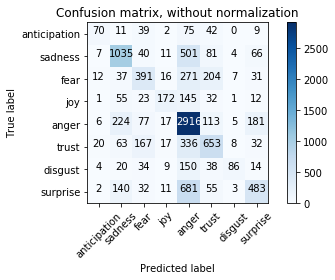

In [76]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

According four confusion matrix, I decide to use <b>TF-IDF including stop word</b> to create features.

---- 

# Training Model

I look for all machine learning model in sklearn, and I decide to use these three to test which has more accuracy.

- Naive_Bayes
- LogisticRegression

In [413]:
all_data_sentences = train_df['text'].append(test_df['text'])

In [414]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=65000,ngram_range=(1,3),
                                tokenizer=my_string_Tokenizer,max_df=0.6,lowercase=False)
tfidf_vectorizer.fit(all_data_sentences)

X_train_tfidf = tfidf_vectorizer.transform(train_df['text'])
y_train = train_df['emotion']

## Naive_Bayes

According to HW1, I know MultinomialNB has better performance than others. Therefore, I choose this to train a model.

[0.55086461 0.55062121]

In [322]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
from sklearn.model_selection import cross_val_score
print(cross_val_score(mnb, X_train_tfidf, y_train, cv=2))  


[0.55325817 0.55249678]


--------

## LogisticRegression

[0.58497221 0.58447631]

In [323]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train_label = le.fit_transform(y_train)

In [415]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(C=2, solver='lbfgs',n_jobs=-1)
from sklearn.model_selection import cross_val_score
print(cross_val_score(reg, X_train_tfidf, y_train_label, cv=2))  


[0.5846287  0.58447081]


------


------

# Predict

In [52]:
X_test_tfidf = tfidf_vectorizer.transform(test_df['text'])

In [53]:
reg = LogisticRegression(C=2, solver='lbfgs',n_jobs=-1)
reg.fit(X_train_tfidf,y_train_label)
y_predict = reg.predict(X_test_tfidf)

In [54]:
y_predict

array([1, 7, 1, ..., 5, 4, 5])

In [55]:
y_predict = le.inverse_transform(y_predict)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [56]:
test_df['emotion'] = y_predict
test_df['id'] = test_df['tweet_id']

In [57]:
submission = pd.read_csv('sampleSubmission.csv')
submission = submission.drop('emotion',axis=1)
submission = pd.merge(submission,test_df[['id','emotion']],on='id',how='left')
submission.to_csv('result_file.csv',index=False)

In [58]:
print(submission.shape)
submission[:5]

(411972, 2)


id       emotion
0  0x2c7743           joy
1  0x2c1eed  anticipation
2  0x2826ea       sadness
3  0x356d9a           joy
4  0x20fd95           joy

------

# Deep Learning

In [1]:
import keras

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['text'],train_df['emotion'],test_size = 0.2)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=65000,stop_words='english',ngram_range=(1,3),
                                tokenizer=nltk.word_tokenize,max_df=0.6,lowercase=False)

tfidf_vectorizer.fit(train_df['text'])
X_train_tfidf = tfidf_vectorizer.transform(X_train)

In [12]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [13]:
## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)



check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']

## Before convert
y_train[0:4]:
 936629     anticipation
1220237            fear
515948          sadness
661379          disgust
Name: emotion, dtype: object

y_train.shape:  (1164450,)
y_test.shape:  (291113,)


In [14]:
# I/O check
input_shape = X_train_tfidf.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



input_shape:  65000
output_shape:  8


In [16]:
# training setting
epochs = 5
batch_size = 32

# training!
history = model.fit(X_train_tfidf, y_train, epochs=epochs, batch_size=batch_size)
print('training finish')

Epoch 1/5
1164450/1164450 [==============================] - 2342s 2ms/step - loss: 1.2107 - acc: 0.5616
Epoch 2/5
1164450/1164450 [==============================] - 2250s 2ms/step - loss: 1.0720 - acc: 0.6104
Epoch 3/5
1164450/1164450 [==============================] - 2288s 2ms/step - loss: 0.9765 - acc: 0.6462
Epoch 4/5
1164450/1164450 [==============================] - 2272s 2ms/step - loss: 0.8818 - acc: 0.6836
Epoch 5/5
1164450/1164450 [==============================] - 2261s 2ms/step - loss: 0.7926 - acc: 0.7195
training finish


In [18]:
pred_result = model.predict(X_test_tfidf, batch_size=128)
pred_result = label_decode(label_encoder, pred_result)


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [19]:
from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


testing accuracy: 0.56
